# **I. Importar Librerias**

In [117]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

# **II. Cargar Datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
fake= pd.read_csv("gdrive/MyDrive/DATA/FAKENEWS/Fake.csv", engine='python')
true= pd.read_csv("gdrive/MyDrive/DATA/FAKENEWS/True.csv", engine='python')

# **III. Limpieza de Datos**

*Removing Reuters or Twitter Tweet information from the text*

*Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and text part<br>
*If we do not get text part, this means publication details was't given for that record<br>
*The Twitter tweets always have same source, a long text of max 259 characters

In [ ]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(true.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [ ]:
#Thus we have list of indices where publisher is not mentioned
#lets check
true.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

**Looks like, 8970 index does not have any text**

In [ ]:
true.iloc[8970]
#yep empty
#will remove this soon

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(true.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [ ]:
#Replace existing text column with new text
#add seperate column for publication info
true["publisher"] = publisher
true["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [ ]:
true.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
 #checking for rows with empty text like row:8970
[index for index,text in enumerate(true.text.values) if str(text).strip() == '']
#seems only one :)

[8970]

In [ ]:
#dropping this record
true.drop(8970, axis=0,inplace=True)

In [ ]:
print(true['publisher'].unique())

['WASHINGTON (Reuters)' 'SEATTLE/WASHINGTON (Reuters)'
 'WEST PALM BEACH, Fla./WASHINGTON (Reuters)' ...
 'AL UDEID AIR BASE, Qatar (Reuters)' 'PENEDO, Brazil (Reuters)'
 'BRASILIA/CARACAS (Reuters)']


In [ ]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [ ]:
fake.drop(empty_fake_index, axis=0,inplace=True)

# **IV. Preprocesamietno del Texto**

In [ ]:
# Adding class Information
true["class"] = 1
fake["class"] = 0

In [ ]:
#Combining Title and Text
true["text"] = true["title"] + " " + true["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [ ]:
# Subject is diffrent for real and fake thus dropping it
# And dropping Date, title and Publication Info of real
true = true.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [ ]:
true.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [ ]:
fake.head()

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [ ]:
#Combining both into new dataframe
news_df = true.append(fake, ignore_index=True)
del true, fake

-----


# **V. DIVISIÓN DATOS TESTEO/ENTRENAMIENTO**

In [ ]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [ ]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
max_vocab = 700
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

## VECTORIZACION

In [ ]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

## BUILDING RNN (LSTM)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          22400     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 92,801
Trainable params: 92,801
Non-trainable params: 0
__________________________________________________

In [ ]:
# We are going to use early stop, which stops when the validation loss no longer improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/5
1063/1063 [==============================] - 399s 369ms/step - loss: 0.4921 - accuracy: 0.6697 - val_loss: 0.1216 - val_accuracy: 0.9616
Epoch 2/5
1063/1063 [==============================] - 386s 363ms/step - loss: 0.1229 - accuracy: 0.9659 - val_loss: 0.0920 - val_accuracy: 0.9712
Epoch 3/5
1063/1063 [==============================] - 393s 369ms/step - loss: 0.0874 - accuracy: 0.9756 - val_loss: 0.0859 - val_accuracy: 0.9664
Epoch 4/5
1063/1063 [==============================] - 398s 374ms/step - loss: 0.0664 - accuracy: 0.9788 - val_loss: 0.0762 - val_accuracy: 0.9774
Epoch 5/5
1063/1063 [==============================] - 391s 368ms/step - loss: 0.0565 - accuracy: 0.9843 - val_loss: 0.0789 - val_accuracy: 0.9780


## VISUALIZACIÓN

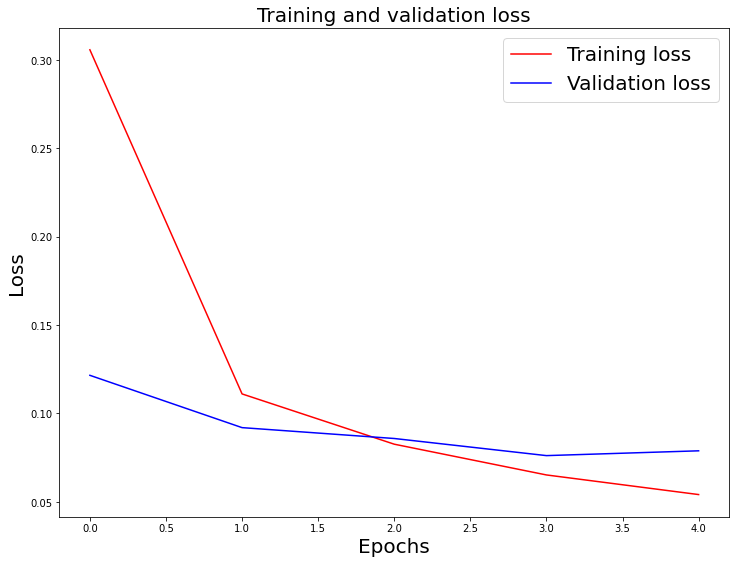

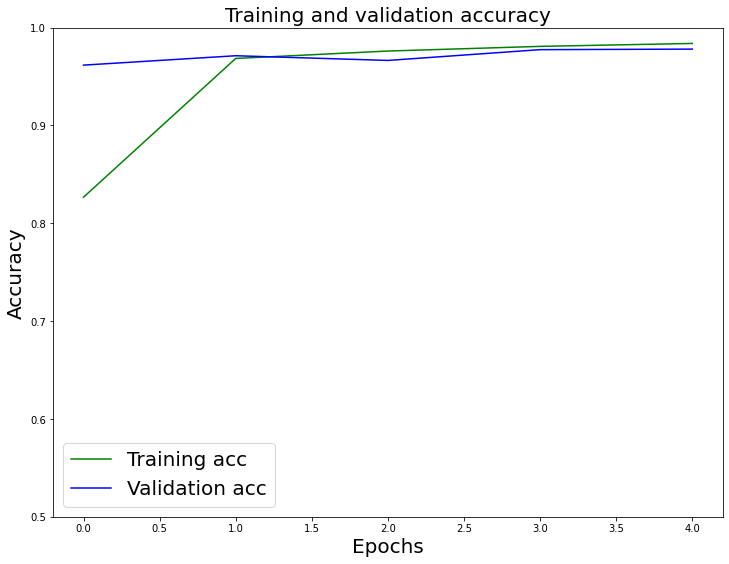

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## EVALUACIÓN DEL MODELO

In [ ]:
model.evaluate(X_test, y_test)

277/277 [==============================] - 22s 78ms/step - loss: 0.0720 - accuracy: 0.9799


[0.0719643086194992, 0.979896068572998]

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9798960921617348
Precision on testing set: 0.981903642773208
Recall on testing set: 0.9763963542883851


In [ ]:
print(classification_report(binary_predictions, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4575
           1       0.98      0.98      0.98      4279

    accuracy                           0.98      8854
   macro avg       0.98      0.98      0.98      8854
weighted avg       0.98      0.98      0.98      8854



## MATRIZ DE CONFUSIÓN

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

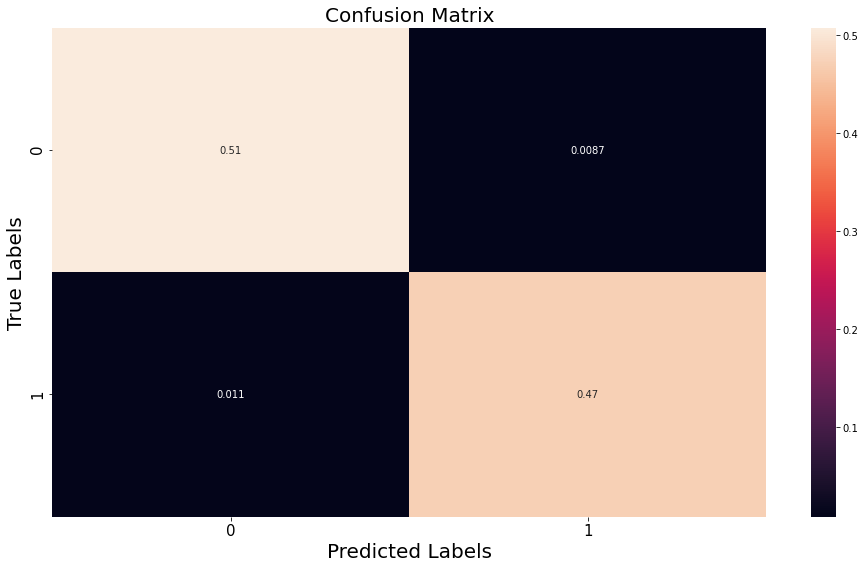

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

PESOS SINÁPTICOS

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(700, 32)


In [ ]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

In [ ]:
print(word_index)